In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from textblob import TextBlob
import spacy
import spacy.util
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
trans = preprocessing.MinMaxScaler()
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.metrics.pairwise import cosine_similarity

/Users/sebastiankrause/Developer/feedback-prize/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
nlp = spacy.load("en_core_web_lg")
download_dir="./.venv/nltk_data"

In [37]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
from tqdm import tqdm
# IN KAGGLE:
# train = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
# test = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")
# from tqdm.notebook import tqdm
display(train.head(2))

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5


## Text Feature Engineering

In [4]:
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

In [5]:
var = 'n_capital'
train[var]=train['full_text'].apply(count_capital_words)
test[var]=test['full_text'].apply(count_capital_words)

### Punctuation

In [6]:
def count_punctuations(text):
    punctuations="'!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'"
    count=0
    for i in punctuations:
        count+=text.count(i)
    return count

In [7]:
var = 'n_punct'
train[var]=train['full_text'].apply(count_punctuations)
test[var]=test['full_text'].apply(count_punctuations)

In [8]:
def text_cleaner(text):
    text = text.strip()
    text = re.sub(r'\n', ' ', text)
    text = text.lower()
    return text

In [9]:
train['full_text']=train['full_text'].apply(text_cleaner)
test['full_text']=test['full_text'].apply(text_cleaner)

### Number of Unique Words

In [10]:
def n_unique_words(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    unique_words = np.unique(words)
    return len(unique_words)

In [11]:
var = 'n_unique'
train[var]=train['full_text'].apply(n_unique_words)
test[var]=test['full_text'].apply(n_unique_words)

<Figure size 500x2000 with 0 Axes>

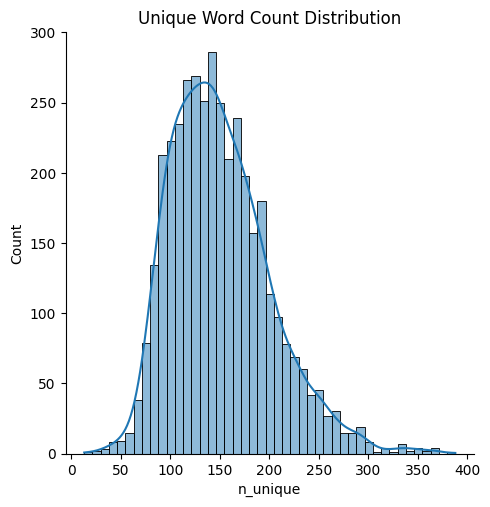

In [12]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Unique Word Count Distribution')
plt.show()

### Number of Unique Words (exclude stop words)

In [13]:
nltk.download('stopwords', download_dir=download_dir)

[nltk_data] Downloading package stopwords to ./.venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
nltk.data.path.append(download_dir)

In [15]:
def n_unique_words_no_stop(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    #remove stop words
    words = [word for word in words if word not in stop_words]
    unique_words = np.unique(words)
    return len(unique_words)

In [16]:
var = 'n_unique_n_stop'
train[var]=train['full_text'].apply(n_unique_words_no_stop)
test[var]=test['full_text'].apply(n_unique_words_no_stop)

<Figure size 500x2000 with 0 Axes>

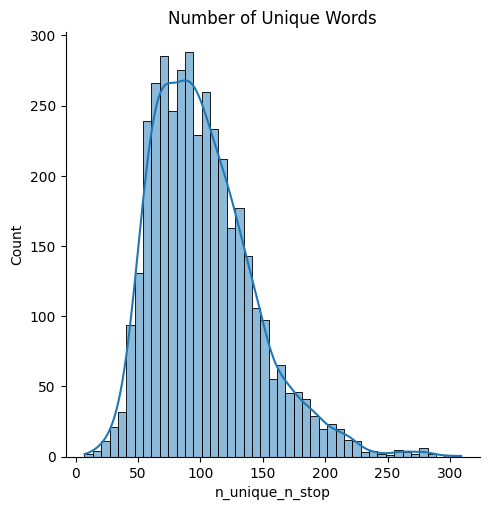

In [17]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Number of Unique Words')
plt.show()

### Number of Non-words

In [18]:
def n_non_words(text):
    text = text.translate(str.maketrans("", "", punctuation))
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    stop_words = ['a', 'i', ' ']
    #remove stop words
    words = [word for word in words if len(word) == 1]
    words = [word for word in words if word not in stop_words]
    unique_words = np.unique(words)
    return len(unique_words)

In [19]:
var = 'n_n_word'
train[var]=train['full_text'].apply(n_non_words)
test[var]=test['full_text'].apply(n_non_words)

<Figure size 500x2000 with 0 Axes>

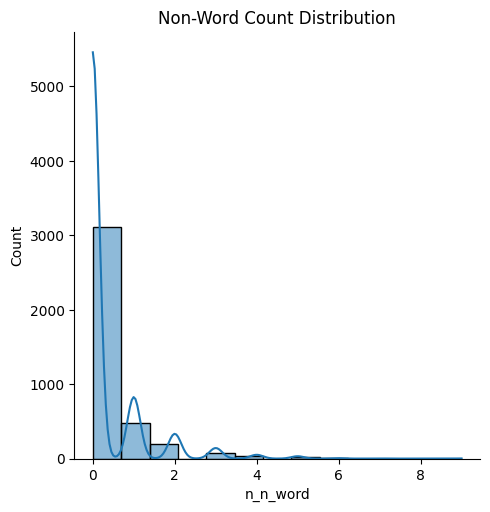

In [20]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Non-Word Count Distribution')
plt.show()

### Number of Noun Phrases

In [21]:
def count_noun_phrases(text):
    blob = TextBlob(text)
    return len(blob.noun_phrases)

In [22]:
var = 'noun_phrase_count'
train[var]=train['full_text'].apply(count_noun_phrases)
test[var]=test['full_text'].apply(count_noun_phrases)

<Figure size 500x2000 with 0 Axes>

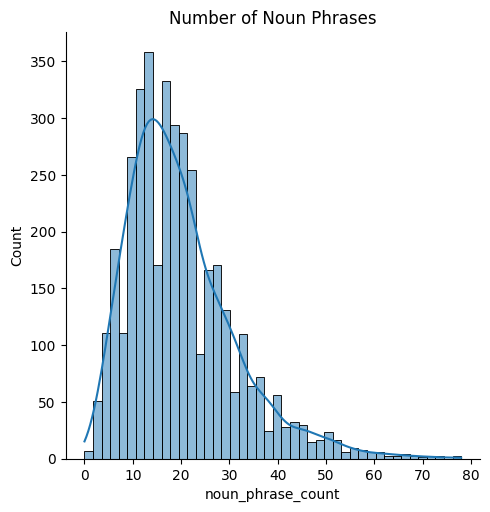

In [23]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x=var,kde="True")
plt.title('Number of Noun Phrases')
plt.show()

### Parts of Speech Tagging

In [24]:
def pos(text):
    doc = nlp(text)
    result = dict(Counter([t.pos_ for t in doc]))
    missing = set(var) - set(result.keys())
    for miss in missing:
        result[miss] = np.nan
    return pd.Series(result)

In [25]:
var = ['PRON', 'VERB',	'SCONJ', 'NOUN', 'AUX', 'ADP', 'PUNCT', 'PART',	'CCONJ', 'ADV', 'DET', 'ADJ', 'SPACE', 'PROPN', 'NUM', 'INTJ', 'SYM', 'X']
train[var]=train['full_text'].apply(pos)

In [26]:
test[var]=test['full_text'].apply(pos)

### Distributions

<Figure size 500x2000 with 0 Axes>

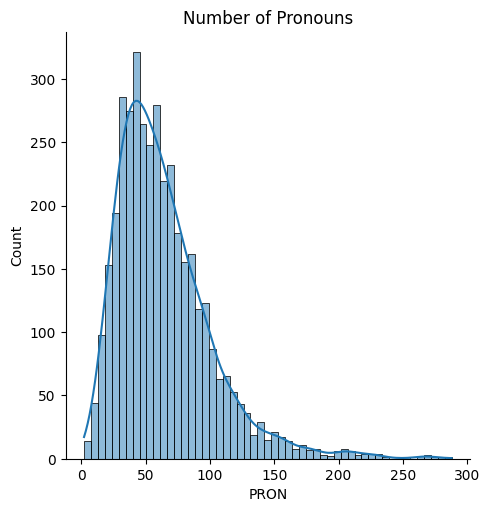

In [27]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x='PRON',kde="True")
plt.title('Number of Pronouns')
plt.show()

<Figure size 500x2000 with 0 Axes>

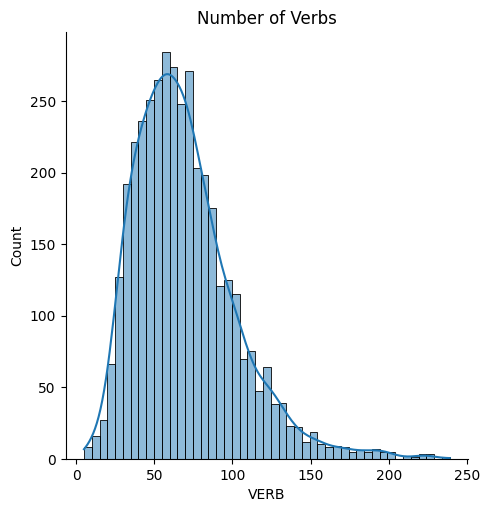

In [28]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x='VERB',kde="True")
plt.title('Number of Verbs')
plt.show()

In [29]:
train = train.fillna(0.0)
test = test.fillna(0.0)

### Sentiment Polarity

In [30]:
def essay_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [31]:
var = 'polarity'
train[var]=train['full_text'].apply(essay_polarity)
test[var]=test['full_text'].apply(essay_polarity)

### Essay Subjectivity

In [32]:
def essay_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [33]:
var = 'subjectivity'
train[var]=train['full_text'].apply(essay_subjectivity)
test[var]=test['full_text'].apply(essay_subjectivity)

### Spelling

TextBlob(text).correct():

"I havv a dreem" -> "I have a dream"

In [34]:
def spell_similarity(text): 
    b = nlp(TextBlob(text).correct().string)
    return nlp(text).similarity(b)

In [38]:
tqdm.pandas()

train['spell_score'] = train['full_text'].progress_apply(spell_similarity)
test['spell_score'] = test['full_text'].progress_apply(spell_similarity)

100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


### Sentence Statistics

In [39]:
def sentence_av_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.mean(list(sent_len))

train['av_sent_len']=train['full_text'].apply(sentence_av_len_calc)
test['av_sent_len']=test['full_text'].apply(sentence_av_len_calc)

In [40]:
def sentence_max_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.max(list(sent_len))

train['max_sent_len']=train['full_text'].apply(sentence_max_len_calc)
test['max_sent_len']=test['full_text'].apply(sentence_max_len_calc)

In [41]:
def sentence_min_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.min(list(sent_len))

train['min_sent_len']=train['full_text'].apply(sentence_min_len_calc)
test['min_sent_len']=test['full_text'].apply(sentence_min_len_calc)

In [42]:
def sentence_median_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.median(list(sent_len))

train['med_sent_len']=train['full_text'].apply(sentence_median_len_calc)
test['med_sent_len']=test['full_text'].apply(sentence_median_len_calc)

In [43]:
def sentence_std_len_calc(text):
    sentences = pd.Series(text.split("."))
    sent_len = sentences.apply(n_unique_words)
    return np.std(list(sent_len))

train['std_sent_len']=train['full_text'].apply(sentence_std_len_calc)
test['std_sent_len']=test['full_text'].apply(sentence_std_len_calc)

### Number of sentences

In [44]:
def sentence_count(text):
    sentences = text.split(".")
    return len(sentences)

In [45]:
train['num_sent']=train['full_text'].apply(sentence_count)
test['num_sent']=test['full_text'].apply(sentence_count)

<Figure size 500x2000 with 0 Axes>

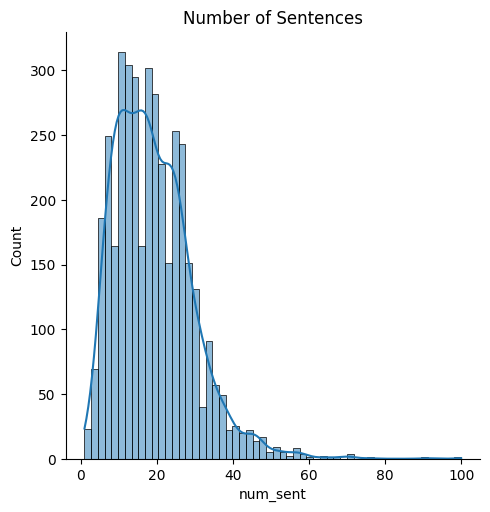

In [46]:
plt.figure(figsize=(5,20))
sns.displot(data=train,x='num_sent',kde="True")
plt.title('Number of Sentences')
plt.show()

### Sentiment Scores

In [47]:
nltk.download('vader_lexicon', download_dir=download_dir)

[nltk_data] Downloading package vader_lexicon to ./.venv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

sentiment scores: –4 (very negativ) and +4 (very positiv).

In [48]:
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['full_text'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu
train['compound'],train['negative'],train['positive'],train['neutral']=generate_sentiment_scores(train)
test['compound'],test['negative'],test['positive'],test['neutral']=generate_sentiment_scores(test)

100%|██████████| 3/3 [00:00<00:00, 503.44it/s]


In [49]:
display(train[['full_text', 'compound', 'negative', 'positive', 'neutral']].head(5))

,full_text,compound,negative,positive,neutral
0,I think that students would benefit from learn...,0.9363,0.051,0.099,0.850
1,When a problem is a change you have to let it ...,-0.9194,0.111,0.091,0.798
2,"Dear, Principal\n\nIf u change the school poli...",0.9271,0.054,0.110,0.837
3,The best time in life is when you become yours...,0.9995,0.054,0.242,0.704
4,Small act of kindness can impact in other peop...,0.9868,0.000,0.164,0.836


### Character Length

In [50]:
train['char_len']=train['full_text'].apply(lambda x:len(x.split()))
test['char_len']=test['full_text'].apply(lambda x:len(x.split()))

In [51]:
processed_train = pd.DataFrame()
processed_test = pd.DataFrame()
processed_train["tokens"] = train["full_text"].apply(lambda s: word_tokenize(s))
processed_test["tokens"] = test["full_text"].apply(lambda s: word_tokenize(s))
processed_train["sentences"] = train["full_text"].apply(lambda s: nltk.sent_tokenize(s))
processed_test["sentences"] = test["full_text"].apply(lambda s: nltk.sent_tokenize(s))

### Word Diversity

How many different words contains the text?

In [52]:
def lexical_diversity(tokens):
    return len(set(tokens)) / max(len(tokens), 1)

train["lex_diversity"] = processed_train["tokens"].apply(lexical_diversity)
test["lex_diversity"] = processed_test["tokens"].apply(lexical_diversity)

## TF-IDF

TF: term-frequency

IDF: inversed-document-frequency

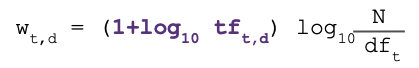

In [53]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10_000,
    min_df=5
)
X_tfidf_train = tfidf.fit_transform(train['full_text'])
X_tfidf_test = tfidf.transform(test['full_text'])

In [54]:
tfidf_means = np.asarray(X_tfidf_train.mean(axis=0)).flatten()
tfidf_features = tfidf.get_feature_names_out()

In [55]:

# Convert to DataFrame
tfidf_df_train = pd.DataFrame(X_tfidf_train.toarray(), columns=tfidf_features, index=train.index)
tfidf_df_test = pd.DataFrame(X_tfidf_test.toarray(), columns=tfidf_features, index=test.index)


In [56]:

# Concatenate to original DataFrames
train = pd.concat([train.reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
test = pd.concat([test.reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)

In [57]:


# Top 20 Features
top_n = 20
top_indices = tfidf_means.argsort()[::-1][:top_n]
top_features = [tfidf_features[i] for i in top_indices]
top_values = tfidf_means[top_indices]

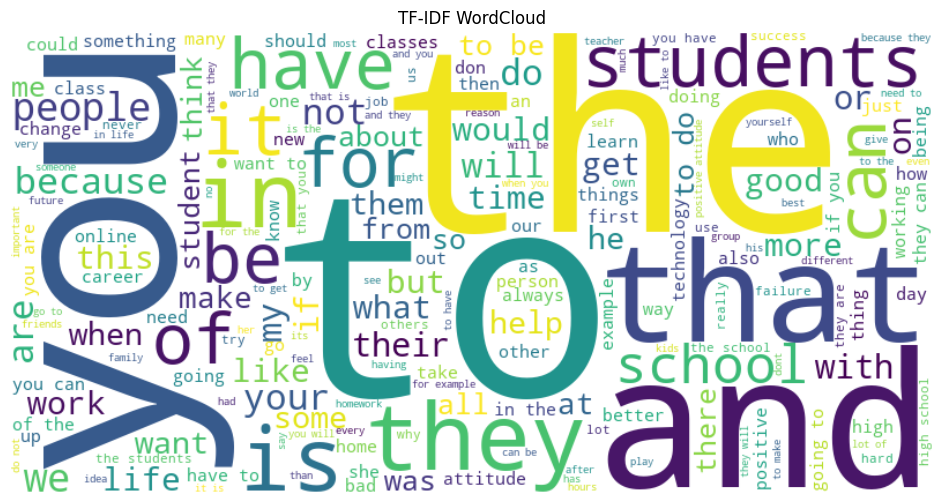

In [58]:
# Dictionary: {feature_name: mean_tfidf_value}
tfidf_dict = {tfidf_features[i]: tfidf_means[i] for i in range(len(tfidf_features))}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("TF-IDF WordCloud")
plt.show()

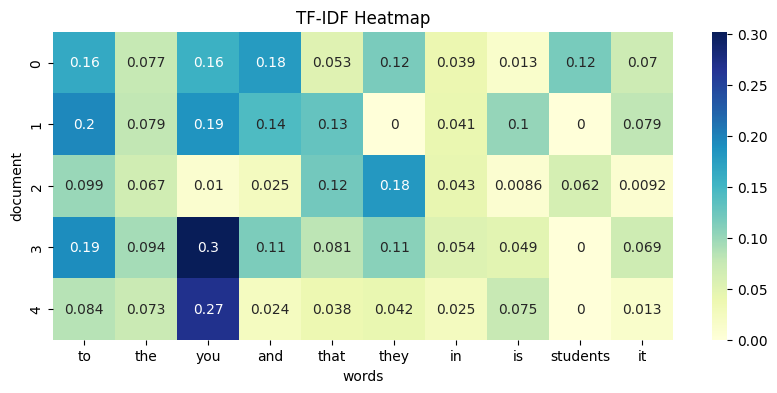

In [59]:
n_docs = 5
top_words = top_features[:10]  # Top 10 words

top_word_indices = [np.where(tfidf_features == word)[0][0] for word in top_words]

# extract TF-IDF-values 
subset = X_tfidf_train[:n_docs, top_word_indices].toarray()

df_heat = pd.DataFrame(subset, columns=top_words)
plt.figure(figsize=(10, 4))
sns.heatmap(df_heat, annot=True, cmap="YlGnBu")
plt.title("TF-IDF Heatmap")
plt.xlabel("words")
plt.ylabel("document")
plt.show()

### Extract the labels

In [60]:
y_train=train[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']]

In [61]:
train.to_csv('data/feature_engineered/train_vars.csv', index=False)
y_train.to_csv('data/feature_engineered/y_vars.csv', index=False)
test.to_csv('data/feature_engineered/test_vars.csv', index=False)

In [62]:
display(train.head(5))

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,spell_score,av_sent_len,...,yourself if,yourself in,yourself is,yourself or,yourself that,yourself to,yourself you,youtube,zone,zoo
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,0.999974,12.368421,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.999829,23.333333,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,0.998618,15.150000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,0.999844,16.837838,...,0.0,0.093427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,0.998649,34.500000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
train.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'spell_score', 'av_sent_len',
       ...
       'yourself if', 'yourself in', 'yourself is', 'yourself or',
       'yourself that', 'yourself to', 'yourself you', 'youtube', 'zone',
       'zoo'],
      dtype='object', length=10021)